In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import joblib

In [2]:
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")
vgg16_model = tf.keras.Model(inputs=vgg16_model.input, 
                              outputs=vgg16_model.get_layer('flatten').output)
for layer in vgg16_model.layers:
    layer.trainable = False

In [3]:
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Extract features for train and test datasets
train_features, train_labels = extract_features(train_generator, vgg16_model)
test_features, test_labels = extract_features(test_generator, vgg16_model)

54/54 [==============================] - 369s 7s/step


In [6]:
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (6185, 25088)
Test features shape: (1724, 25088)


In [7]:
# Apply PCA for dimensionality reduction
print("Before PCA, train features shape:", train_features.shape)
print("Before PCA, test features shape:", test_features.shape)

Before PCA, train features shape: (6185, 25088)
Before PCA, test features shape: (1724, 25088)


In [8]:
# Define and apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)


In [9]:
print(f"After PCA, train features shape: {train_features_pca.shape}")
print(f"After PCA, test features shape: {test_features_pca.shape}")

After PCA, train features shape: (6185, 2281)
After PCA, test features shape: (1724, 2281)


In [10]:
# Train the Random Forest classifier with PCA-reduced features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features_pca, train_labels)
print("Random Forest training complete with PCA.")

Random Forest training complete with PCA.


In [11]:
# Evaluate the Random Forest classifier on the test dataset
test_predictions = rf_classifier.predict(test_features_pca)

# Calculate and print the test accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with PCA: {accuracy:.4f}")

Test Accuracy with PCA: 0.6862


In [12]:
# Print detailed classification report
print("Classification Report with PCA:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))


Classification Report with PCA:
              precision    recall  f1-score   support

      BENIGN       0.51      0.04      0.07       542
   MALIGNANT       0.69      0.98      0.81      1182

    accuracy                           0.69      1724
   macro avg       0.60      0.51      0.44      1724
weighted avg       0.63      0.69      0.58      1724



1/1 [==============================] - 0s 424ms/step


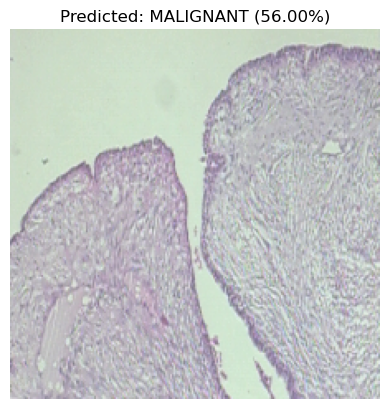

Prediction Probabilities:
BENIGN: 44.00%
MALIGNANT: 56.00%


In [13]:
# Function to make predictions on a single image
def predict_image(image_path, model, rf_classifier, pca, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using VGG16
    features = model.predict(img_array)

    # Apply PCA to the features
    features_pca = pca.transform(features)

    # Predict using the trained Random Forest classifier
    prediction = rf_classifier.predict(features_pca)
    probabilities = rf_classifier.predict_proba(features_pca)

    # Get class labels
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    predicted_probabilities = probabilities[0]

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({max(predicted_probabilities) * 100:.2f}%)")
    plt.show()

    # Print detailed probabilities
    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), predicted_probabilities):
        print(f"{class_label}: {prob * 100:.2f}%")

# Example usage for predicting a single image
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\phyllodes_tumor\SOB_B_PT_14-21998AB\40X\SOB_B_PT-14-21998AB-40-007.png"
predict_image(image_path, vgg16_model, rf_classifier, pca, train_generator.class_indices)

1/1 [==============================] - 0s 285ms/step


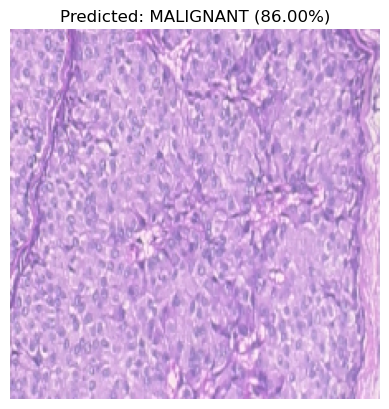

Prediction Probabilities:
BENIGN: 14.00%
MALIGNANT: 86.00%


In [14]:
# Function to make predictions on a single image
def predict_image(image_path, model, rf_classifier, pca, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using VGG16
    features = model.predict(img_array)

    # Apply PCA to the features
    features_pca = pca.transform(features)

    # Predict using the trained Random Forest classifier
    prediction = rf_classifier.predict(features_pca)
    probabilities = rf_classifier.predict_proba(features_pca)

    # Get class labels
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    predicted_probabilities = probabilities[0]

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({max(predicted_probabilities) * 100:.2f}%)")
    plt.show()

    # Print detailed probabilities
    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), predicted_probabilities):
        print(f"{class_label}: {prob * 100:.2f}%")

# Example usage for predicting a single image
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\mucinous_carcinoma\SOB_M_MC_14-13413\100X\SOB_M_MC-14-13413-100-014.png"
predict_image(image_path, vgg16_model, rf_classifier, pca, train_generator.class_indices)

In [15]:
import joblib

# Assuming rf_classifier, pca, and vgg16_model are already defined and trained

# Save Random Forest model
joblib.dump(rf_classifier, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\random_forest_model_with_pca.pkl')
print("Random Forest model saved to random_forest_model_with_pca.pkl")

# Save PCA model
joblib.dump(pca, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')
print("PCA model saved to pca_model.pkl")

# Save VGG16 feature extractor model
vgg16_model.save(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\vgg16_feature_extractor_with_pca.h5')
print("VGG16 feature extractor model saved to vgg16_feature_extractor_with_pca.h5")


Random Forest model saved to random_forest_model_with_pca.pkl
PCA model saved to pca_model.pkl
VGG16 feature extractor model saved to vgg16_feature_extractor_with_pca.h5


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
